## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

##### 7.1.1 Загрузка и подготовка данных

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_data = './datasets/madrid.txt'
madrid = np.loadtxt(path_data)[:,0]
print(madrid.shape)

(25000,)


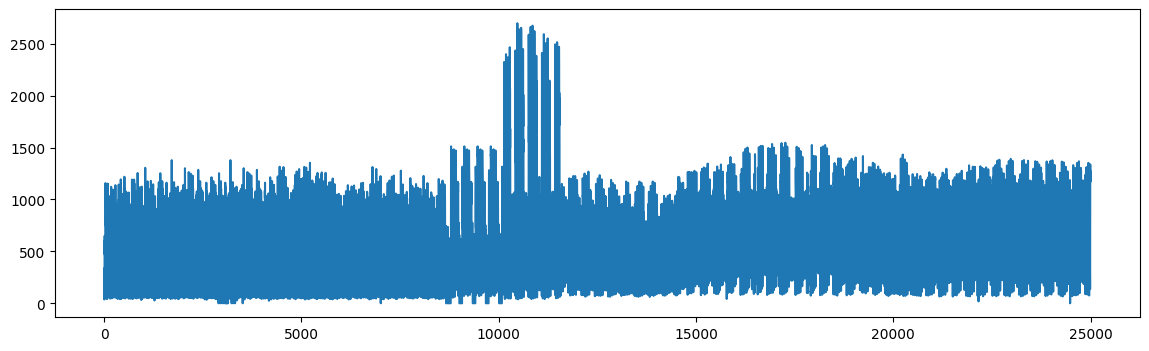

In [3]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значений
   
Процент пропущенных значений должен регулироваться отдельным параметром.


In [4]:
import random
import copy
import torch
def add_nan(x, percent = 0.25):
    x_nan = copy.deepcopy(x)
    nan_len = x.shape[0] * percent
    nan_counter = 0

    for i in range(x_nan.shape[0]):
        if nan_counter <= nan_len and random.randint(0, 1):
            x_nan[i] = np.nan
            nan_counter += 1

    return x_nan, np.isnan(x_nan)

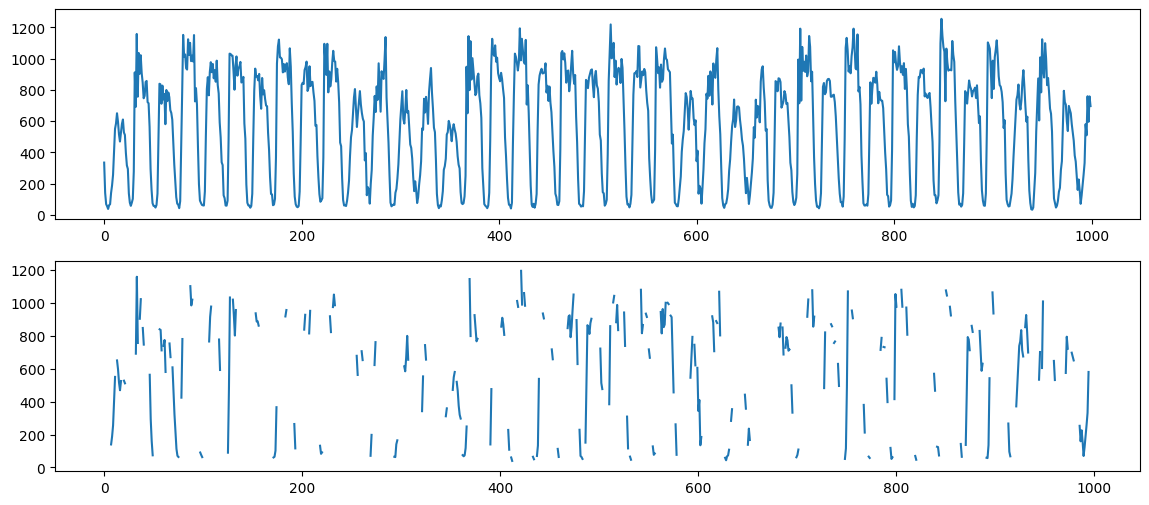

In [5]:
madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_with_nan[:1000])
plt.show()

In [6]:
recovery = {}

##### 7.1.2 Заполнение существующими значениями ряда


In [7]:
madrid_mean = madrid_with_nan.copy()
madrid_mean[index] = np.nanmean(madrid_mean)
recovery['mean'] = madrid_mean

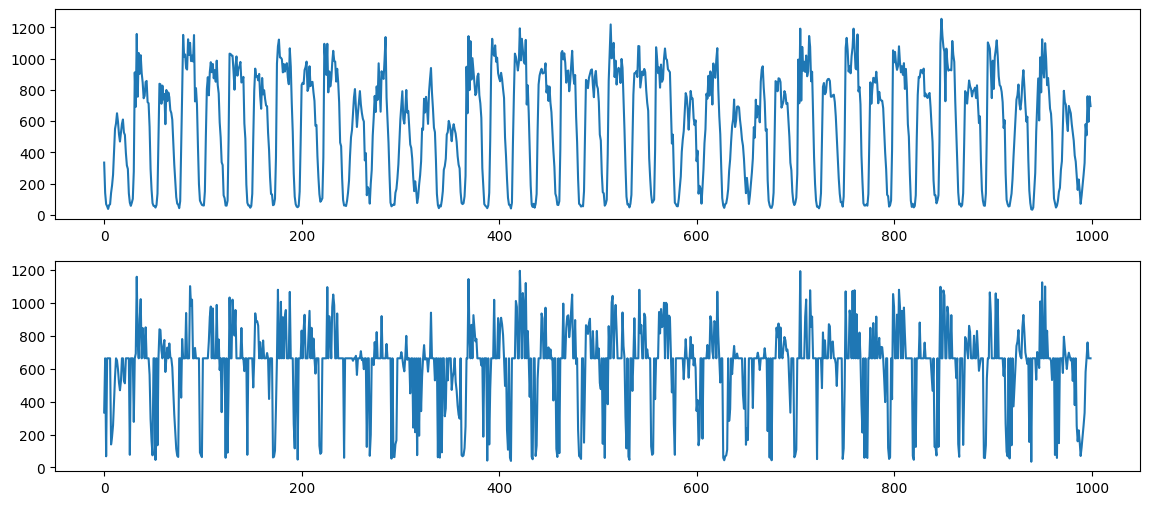

In [8]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_mean[:1000])
plt.show()

In [9]:
madrid_median = madrid_with_nan.copy()
madrid_median[index] = np.nanmedian(madrid_median)

In [10]:
recovery['median'] = madrid_median

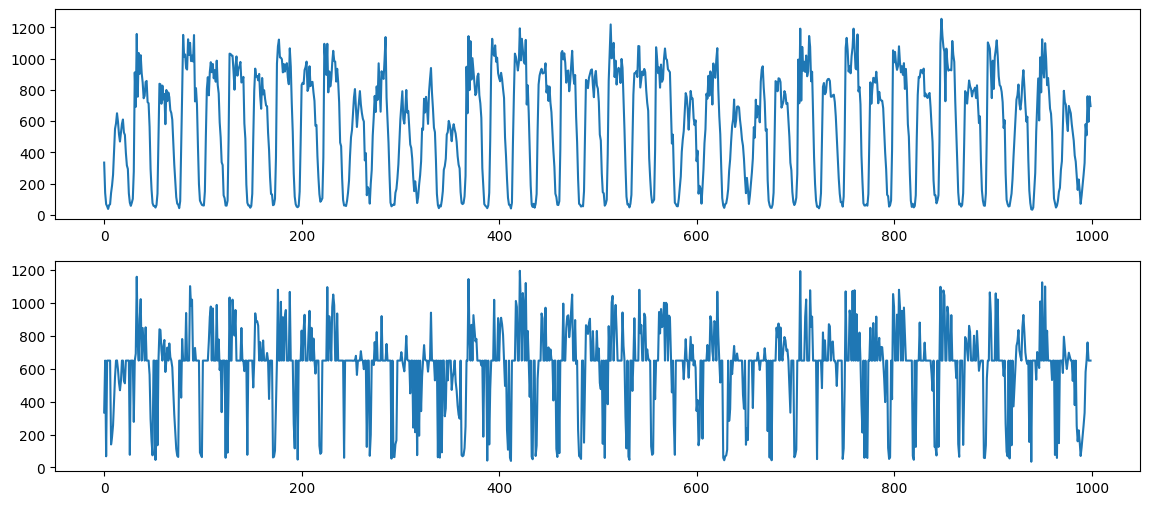

In [11]:
#madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_median[:1000])
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7.1*** и проведите постановление данных, сохранив результаты восстановления.

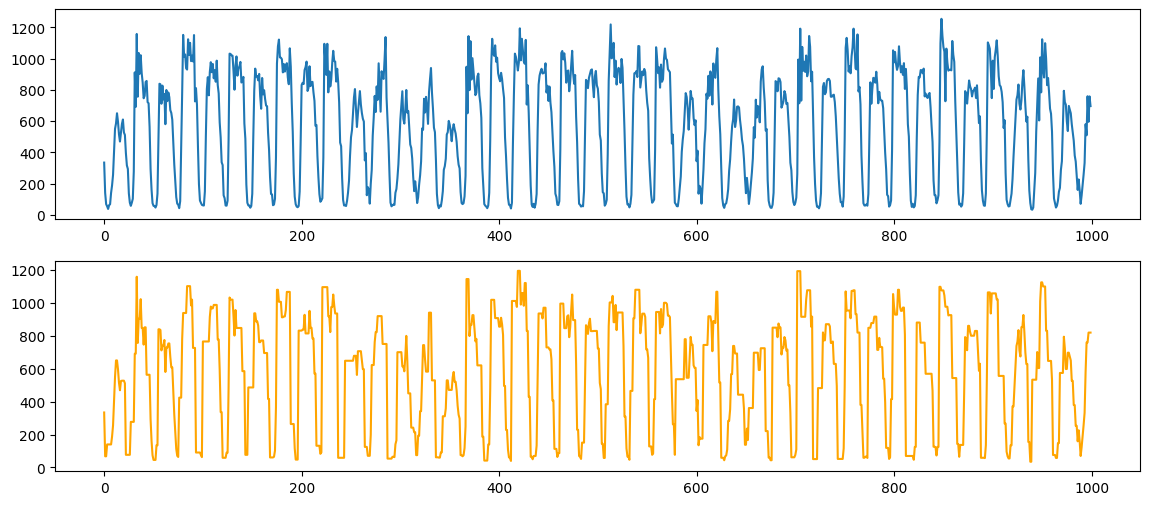

In [12]:
def hot_deck(ts, index):
  hot_deck = ts.copy()

  found_right = False
  for i in range(len(hot_deck)):
    if (index[i]):
      for right_ix in range(i, len(hot_deck)):
        if not (index[right_ix]):
           next = hot_deck[right_ix]
           found_right = True
           break
      if (found_right):
        hot_deck[i] = next
      else:
        hot_deck[i] = hot_deck[i-1]
  return hot_deck

madrid_hot_deck = hot_deck(madrid_with_nan, index)
recovery['hot_deck'] = madrid_hot_deck

fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_hot_deck[:1000], c='orange')
plt.show()

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов восстановления второй группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [13]:
from sklearn.impute import KNNImputer

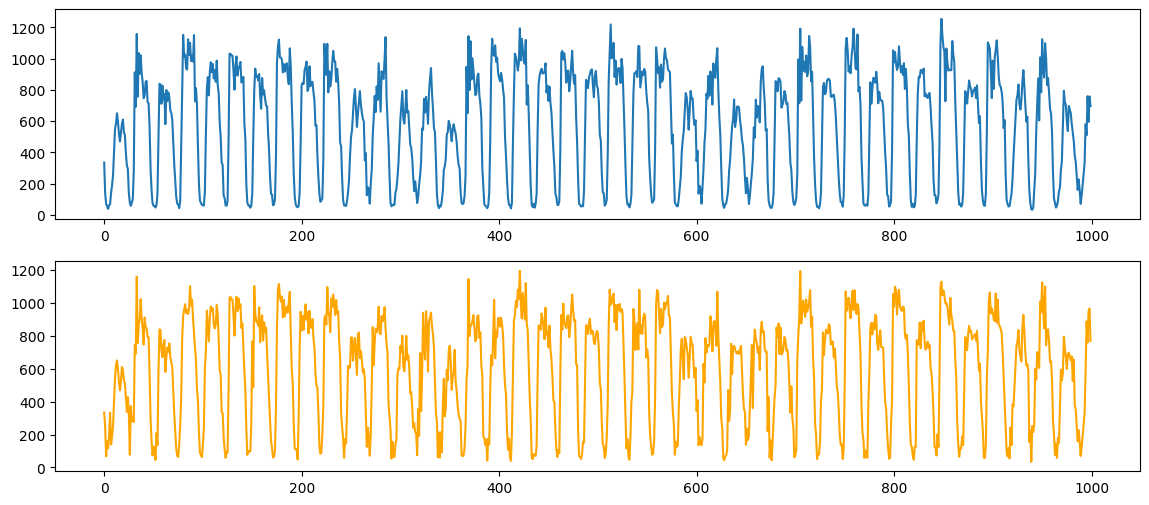

In [14]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)


madrid_slice = rolling_window(madrid_with_nan, 100)

imputer = KNNImputer(n_neighbors=10)

madrid_knn = imputer.fit_transform(madrid_slice)
madrid_knn = madrid_knn.ravel()

recovery['knn'] = madrid_knn

fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_knn[:1000], c="orange")
plt.show()


##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов восстановления третей группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [15]:
!pip install fancyimpute


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from fancyimpute import IterativeSVD

In [17]:
from sklearn.metrics import mean_squared_error

[IterativeSVD] Iter 1: observed MAE=344.871663
[IterativeSVD] Iter 2: observed MAE=269.734341
[IterativeSVD] Iter 3: observed MAE=260.519218
[IterativeSVD] Iter 4: observed MAE=258.033814
[IterativeSVD] Iter 5: observed MAE=257.279537
[IterativeSVD] Iter 6: observed MAE=257.020068
[IterativeSVD] Iter 7: observed MAE=256.917614
[IterativeSVD] Iter 8: observed MAE=256.875393
[IterativeSVD] Iter 9: observed MAE=256.854542
[IterativeSVD] Iter 10: observed MAE=256.843973


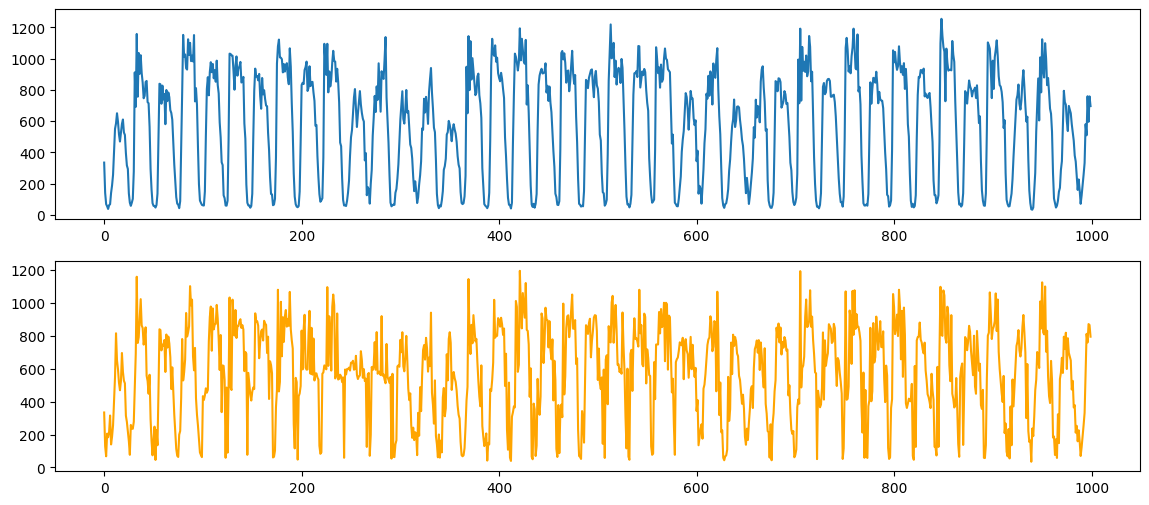

In [18]:
from fancyimpute import IterativeSVD

solver = IterativeSVD(rank=2)
madrid_iterative_svd = madrid_slice.copy()
madrid_iterative_svd = solver.fit_transform(madrid_iterative_svd)
madrid_iterative_svd = madrid_iterative_svd.ravel()

recovery['iterative_svd'] = madrid_iterative_svd

fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_iterative_svd[:1000], c='orange')
plt.show()

##### 7.1.5 Сравнение результатов восстановления.

Для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов.
Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print('mean_squared_error')
MSE = {}
for method in recovery:
    MSE[method] = mean_squared_error(madrid, recovery[method])
    print(f'{method}: {mean_squared_error(madrid, recovery[method])}')

print('\nmean_absolute_error')
MAE = {}
for method in recovery:
    MAE[method] = mean_absolute_error(madrid, recovery[method])
    print(f'{method}: {mean_absolute_error(madrid, recovery[method])}')

print('\nr2_score')
R2 = {}
for method in recovery:
    R2[method] = r2_score(madrid, recovery[method])
    print(f'{method}: {r2_score(madrid, recovery[method])}')

mean_squared_error
mean: 42822.878248433015
median: 42412.36504
hot_deck: 20548.0384
knn: 12337.7626
iterative_svd: 30023.449192425385

mean_absolute_error
mean: 83.85932854018881
median: 83.46088
hot_deck: 43.17016
knn: 38.312368
iterative_svd: 68.54072655704356

r2_score
mean: 0.7259549043134373
median: 0.728581984418445
hot_deck: 0.8685027868320547
knn: 0.9210444633669896
iterative_svd: 0.8078648763624398


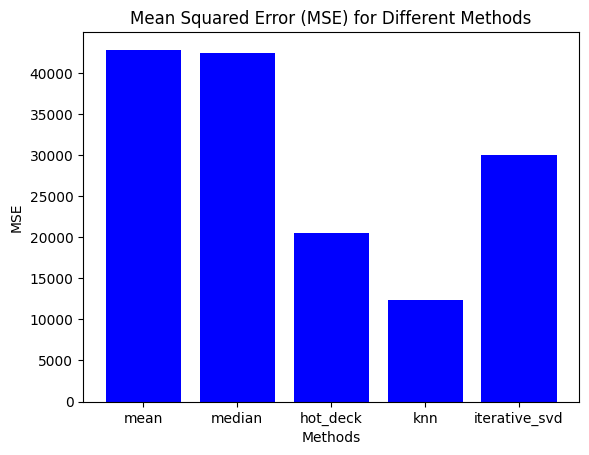

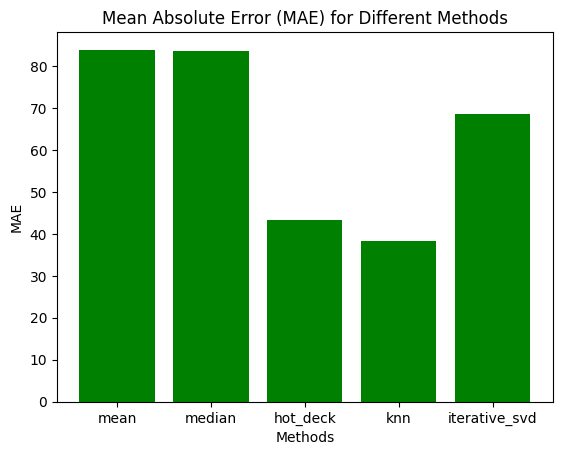

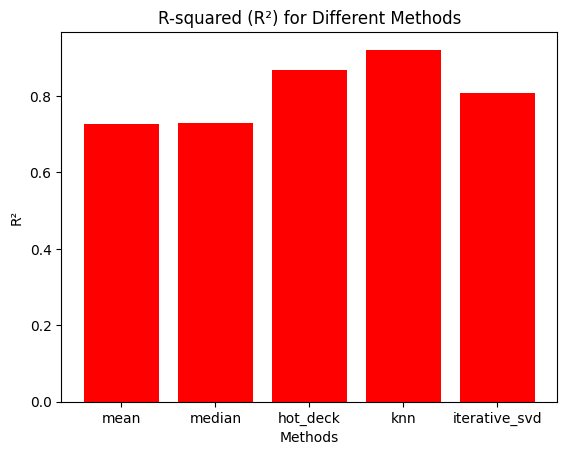

In [20]:
methods = recovery.keys()
# График для MSE
plt.bar(methods, MSE.values(), color='blue')
plt.title('Mean Squared Error (MSE) for Different Methods')
plt.xlabel('Methods')
plt.ylabel('MSE')
plt.show()

# График для MAE
plt.bar(methods, MAE.values(), color='green')
plt.title('Mean Absolute Error (MAE) for Different Methods')
plt.xlabel('Methods')
plt.ylabel('MAE')
plt.show()

# График для R²
plt.bar(methods, R2.values(), color='red')
plt.title('R-squared (R²) for Different Methods')
plt.xlabel('Methods')
plt.ylabel('R²')
plt.show()

*Вывод*: Наиболее хорошо справляется knn, hot_deck и заполнение на основе матричных преобразований тоже неплохо справляются, а заполнение средним или медианным значением показывает худшие результаты

#### **7.2 Нейросетевые методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с некоторыми нейросетевыми методами восстановления временных рядов.
Для выполнения данного пункта вам предстоит самостоятельно реализовать структуру нейросетевой, модели основанной на GRU нейронах и сравнить ее с другими нейросетевыми методами восстановления При сравнении с 3 группой из **табл.7. 2** вам необходимо выбрать **один** метод восстановления. Основные блоки обработки данных будут реализованы с использованием Pytorch. Вам не запрещается использовать для реализации Keras.

**табл. 7.2** - Нейросетевые методы восстановления.
№|Название группы|Модели и методы|
--|-------------|----|
1|Линейные нейроны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)|
 2eкрркуретные нейронны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)|
3|Сложные структуры|[SAITS, BRITS, M-RNN](https://github.com/WenjieDu/PyPOTS)|

In [21]:
recovery_nn = {}

##### 7.2.1 Загрузка и подготовка данных

In [22]:
path_data = './datasets/madrid.txt'
madrid = np.loadtxt(path_data)[:,:]
print(madrid.shape)

(25000, 10)


In [23]:
madrid_with_nan, index = add_nan(madrid, 0.25)

In [24]:
madrid_with_nan.shape

(25000, 10)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
madrid_normal_with_nan = scaler.fit_transform(madrid_with_nan)
rolling_madrid = rolling_window(madrid_normal_with_nan, 100, True)
train, test = train_test_split(rolling_madrid,shuffle=False, test_size=0.33)

##### 7.2.2 Базовая модель восстановления данных, построенная на нескольких слоях линейных нейронов.


Вам необходимо будет самостоятельно реализовать:
1. инициализацию nan значений какими либо другими значениями.
2. замер времени полного обучения и тестирования модели.

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [49]:
class LinearModel(nn.Module):
    def __init__(self, size_subsequent: int,dim = 1, nums_layers = 3, size_layers = 250):
        super().__init__()

        self.size_subsequent = size_subsequent
        self.nums_layers = nums_layers*dim
        self.dim = dim
        self.size_layers = size_layers

        self.start_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(size_subsequent*dim, self.size_layers),
                                          nn.LeakyReLU())
        self.model = nn.ModuleList([
                                        (nn.Sequential(
                                                nn.Linear(self.size_layers, self.size_layers), nn.LeakyReLU()
                                            )
                                        )
                                    for x in torch.arange(nums_layers)])
        self.model = nn.Sequential(*self.model)

        self.output = nn.Sequential(nn.Linear(self.size_layers,size_subsequent*dim),nn.Tanh())

    def forward(self, x):
        x = self.start_layers(x)

        x=self.model(x)
        x=self.output(x)
        return x.reshape(x.shape[0],self.size_subsequent,self.dim)

In [55]:
model = LinearModel(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)

print(train.shape,test.shape)
epochs = 100

(16683, 100, 10) (8217, 100, 10)


In [56]:
model

LinearModel(
  (start_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=250, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=250, out_features=1000, bias=True)
    (1): Tanh()
  )
)

In [57]:
import time
times_model = {}

In [58]:
model=model.to(device)
train_history = []
valid_history = []

start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            X[torch.isnan(X)]=0.0
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    print('valid')
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                X[torch.isnan(X)]=0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\483432832.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x_nan, np.isnan(x_nan)
C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\360513906.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\360513906.py:19: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])


valid


C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\360513906.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\360513906.py:34: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])


epoch:1 train:0.03249012361997845, valid:0.03074448482068472
valid
epoch:2 train:0.030897591191690086, valid:0.0303236716102029
valid
epoch:3 train:0.031019190283513617, valid:0.0316783578041219
valid
epoch:4 train:0.03042989035789994, valid:0.03070242057532765
valid
epoch:5 train:0.030394355163434913, valid:0.030793599842130676
valid
epoch:6 train:0.030824605996410053, valid:0.03108072867111642
valid
epoch:7 train:0.030716977592457756, valid:0.03042472243424534
valid
epoch:8 train:0.0311194794017008, valid:0.03136139132024706
valid
epoch:9 train:0.030361442637569146, valid:0.030362966102223065
valid
epoch:10 train:0.030573963733582663, valid:0.03176156741877397
valid
epoch:11 train:0.03045767357294587, valid:0.03141803033072357
valid
epoch:12 train:0.030809768536252995, valid:0.03126453300721423
valid
epoch:13 train:0.03021427107639468, valid:0.030701579814848973
valid
epoch:14 train:0.03078706481875816, valid:0.0313460164407427
valid
epoch:15 train:0.030469422831674645, valid:0.03167

In [32]:
times_model['linear']=end-start

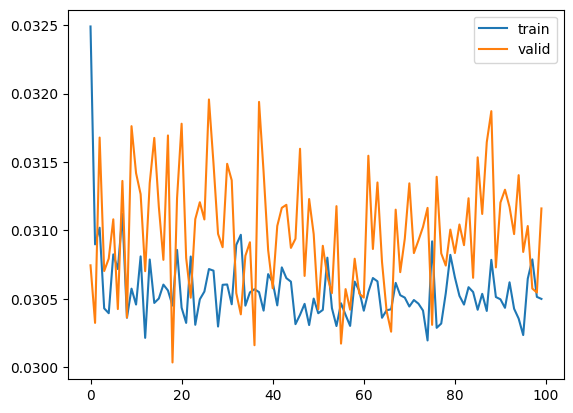

In [59]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [60]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        batch[nan]=0.0
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [61]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_linear = scaler.inverse_transform(test_madrid_normal)

In [62]:
recovery_nn['linear'] = test_linear

871478.2478698533


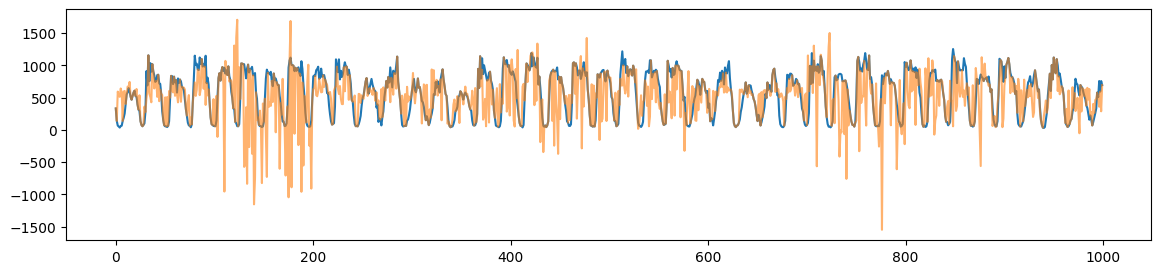

In [63]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_linear[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_linear[index].reshape(1,-1)))

##### 7.2.3 Реккурентная модель востановлениях данных


In [64]:
class EncoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=dim,
                          hidden_size=self.hidden_size)
        
        self.latten = nn.Linear(hidden_size*size_subsequent,latten_size)
        self.leaky = nn.LeakyReLU()
        self.fl = nn.Flatten()
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.leaky(x)
        #print(x.shape)
        x = self.fl(x)
        x = self.latten(x)
        return self.leaky(x)
        

In [65]:
class DecoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.latten_size=latten_size
        self.gru = nn.GRU(input_size=self.hidden_size,
                          hidden_size=dim)
        self.latten = nn.Linear(latten_size,hidden_size*size_subsequent)
        self.leaky = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.latten(x)
        x = x.view(-1, self.size_subsequent, self.latten_size)
        x = self.leaky(x)
        x, _ = self.gru(x)
        return self.leaky(x)
        

In [66]:
class TimeAE(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.encoder = EncoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
        self.decoder = DecoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
    def forward(self, x):
        x=self.encoder(x)
        x = self.decoder(x)
        return x

In [67]:
model = TimeAE(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


epochs = 100

In [68]:
model

TimeAE(
  (encoder): EncoderGRU(
    (gru): GRU(10, 100)
    (latten): Linear(in_features=10000, out_features=100, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
    (fl): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): DecoderGRU(
    (gru): GRU(100, 10)
    (latten): Linear(in_features=100, out_features=10000, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
  )
)

In [ ]:
model=model.to(device)
train_history = []
valid_history = []
start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0]==batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            X[torch.isnan(X)]=0.0

            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0]==batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                X[torch.isnan(X)]=0.0

                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\483432832.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return x_nan, np.isnan(x_nan)
C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\2311916585.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
C:\Users\mdryo\AppData\Local\Temp\ipykernel_14136\2311916585.py:19: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
C:\Users\mdryo\PycharmProjects\2024-Dremin-TimeSeriesCourse\.venv\Lib\site-packages\torch\autograd\graph.py:825: 

epoch:1 train:0.03150764184065477, valid:0.03125077402291372
epoch:2 train:0.030599170467919774, valid:0.030763410392773242


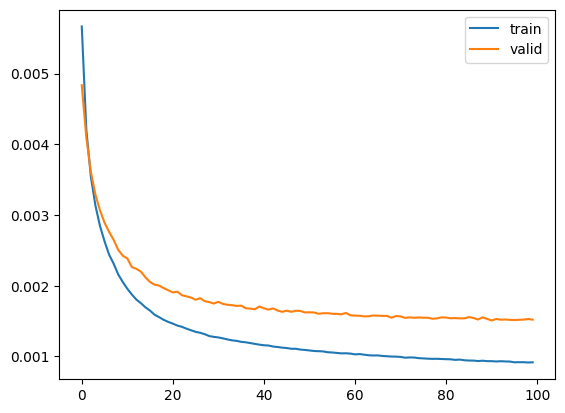

In [60]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [62]:
times_model['ae']=end-start

In [63]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        #
        
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [64]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_ae = scaler.inverse_transform(test_madrid_normal)

In [65]:
recovery_nn['test_ae'] = test_ae

7815.347353696892


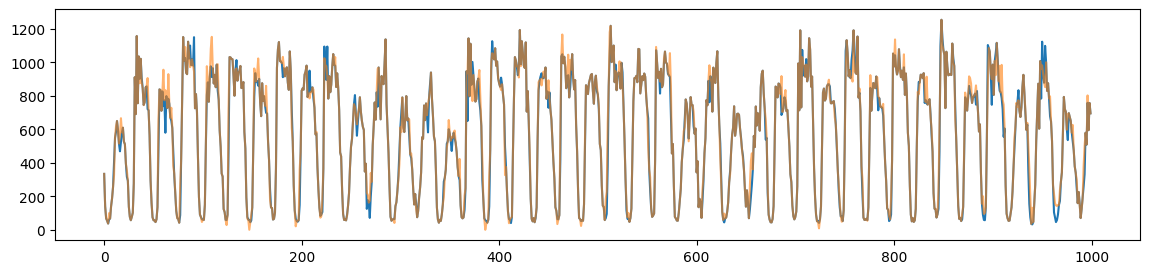

In [66]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_ae[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_ae[index].reshape(1,-1)))

##### 7.2.4 Сложные модели нейросетевого восстановления данных


Вам необходимо выбрать одну модель из 3 группы таблицы 7.2 и используя документацию произвести восстановления того же ряда. Произведите замер времени.

In [39]:
!pip install pypots==0.0.9

  Obtaining dependency information for pypots==0.0.9 from https://files.pythonhosted.org/packages/9d/8d/d4503012afdc98a8b699d285ce220c07fb59af036959f5eca91b90e339e2/pypots-0.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for tensorboard from https://files.pythonhosted.org/packages/b1/de/021c1d407befb505791764ad2cbd56ceaaa53a746baed01d2e2143f05f18/tensorboard-2.18.0-py3-none-any.whl.metadata
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Obtaining dependency information for pycorruptor from https://files.pythonhosted.org/packages/c2/c5/fa1f299db64bd4fb6d2048c16860a6068c311c2af344ba2b554fad5d6790/pycorruptor-0.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for tsdb from https://files.pythonhosted.org/packages/47/d3/85153d802c68539113e5deffcf23ab0e08660aa283e04d45c943b7c13d01/tsdb-0.6.2-py3-none-any.whl.metadata
  Using cached tsdb-0.6.2-py3-none-any.whl.metadata (13 kB)
  Obtaining dependency information for absl-py>=0.4 from ht


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
from pypots.imputation import SAITS


In [68]:
model= SAITS(n_features=madrid.shape[1],
             n_steps=100,
             device=device,
             d_k=64,
             d_v=64,
             d_model=128,
             d_inner=128,
             n_head=4,
             n_layers=2,
             dropout=0.05,
             epochs=100)

Model initialized successfully. Number of the trainable parameters: 667608


In [ ]:
start = time.time()
model.fit(train,test)
end = time.time()
times_model['saits']=end-start

epoch 0: training loss 0.1332, validating loss 0.0487
epoch 1: training loss 0.0748, validating loss 0.0418


In [124]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
test_rolling_madrid = model.impute(test_rolling_madrid)


In [125]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_saits = scaler.inverse_transform(test_madrid_normal)

In [130]:
recovery_nn['saits'] = test_saits

4653.035675034267


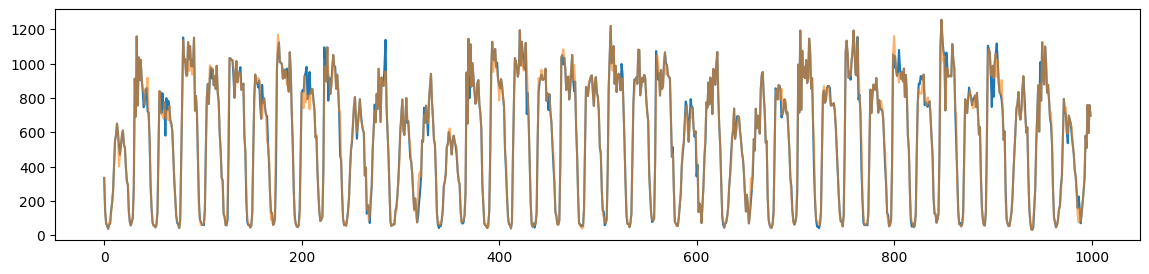

In [126]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_saits[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_saits[index].reshape(1,-1)))

##### 7.2.5 Сравнения результатов.
Также, как и в пункте 7.1.5 постройте графики сравнения моделей. Дополнительно постройте графики сравнения времени. Сделайте выводы

#### **7.3 Прогноз временного ряда**

##### *Краткое описание*

Используя модель и [ARIMA](реализация) произвидите прогноз ряда на следующие колличество точек: 1, 5, 10.
Сравните результаты. Постройте графики прогноза и точности прогноза.